In [3]:
import torch
if not hasattr(torch, "get_default_device"):
    def _get_default_device():
        # always use CPU by default
        return torch.device("cpu")
    torch.get_default_device = _get_default_device

# probabilistic programming
import pyro 

# MCMC plotting
import arviz as az
import matplotlib.pyplot as plt
from getdist.arviz_wrapper import arviz_to_mcsamples
from getdist import plots

# autoemulate imports
from autoemulate.simulations.epidemic import Epidemic
from autoemulate.core.compare import AutoEmulate
from autoemulate.calibration.bayes import BayesianCalibration
from autoemulate.emulators import GaussianProcessRBF

# suppress warnings in notebook for readability
import os
import warnings

# ignore warnings
warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

# random seed for reproducibility
random_seed = 42

In [5]:
from autoemulate.data.utils import set_random_seed
set_random_seed(random_seed)
pyro.set_rng_seed(random_seed)

# Bayesian calibration

Bayesian calibration is a method for estimating which input parameters were most likely to produce observed data. An advantage over other calibration methods is that it returns a probability distribution over the input parameters rather than just point estimates.

Performing Bayesian calibration requires:
- a simulator or an emulator trained to approximate the simulator
- observations associated with the simulator/emulator output



## 1. Simulate data

In this example, we'll use the `Epidemic` simulator, which returns the peak infection rate given two input parameters, `beta`(the transimission rate per day) and `gamma` (the recovery rate per day).

In [6]:
simulator = Epidemic(log_level="error")
x = simulator.sample_inputs(1000)
y, _ = simulator.forward_batch(x)

Below we plot the simulated data. The peak infection rate is higher when the transmission rate increases and the recovery rate decreases and the two parameters are correlated with each other.

<function matplotlib.pyplot.show(close=None, block=None)>

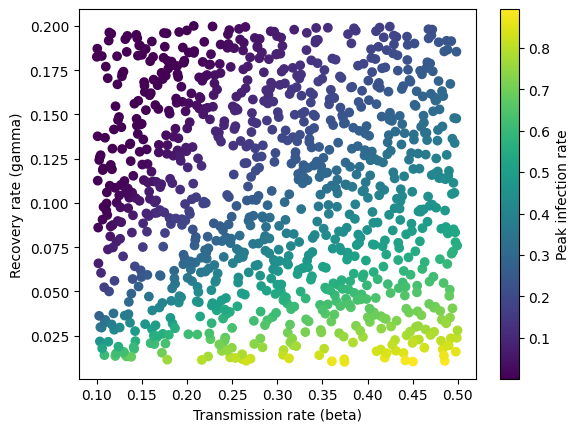

In [7]:
transmission_rate = x[:, 0]
recovery_rate = x[:, 1]

plt.scatter(transmission_rate, recovery_rate, c=y, cmap='viridis')
plt.xlabel('Transmission rate (beta)')
plt.ylabel('Recovery rate (gamma)')
plt.colorbar(label="Peak infection rate")
plt.show

Calibration requires at least one or multiple observations. These can come from running experiments or from the literature.

Below we pick the initial parameter values and simulate the output. We then add noise to generate 100 "observations". 

In [8]:
true_beta = 0.3
true_gamma = 0.15 

# simulator expects inputs of shape [1, number of inputs]
params = torch.tensor([true_beta, true_gamma]).view(1, -1)
true_infection_rate = simulator.forward(params)

n_obs = 100
stdev = 0.05
noise = torch.normal(mean=0, std=stdev, size=(n_obs,))
observed_infection_rates = true_infection_rate[0] + noise

observations = {"infection_rate": observed_infection_rates}

We can now use these observations to infer which input parameters were most likely to have produced them.

## 2. Calibrate with simulator

In this example, we have a fast simulator with only two input parameters, so we can use the simulator for calibration. The below code shows how to do this directly with Pyro. We can then compare this approach with using an emulator for calibration.

In [9]:
import pyro.distributions as dist
from pyro.infer import MCMC
from pyro.infer.mcmc import RandomWalkKernel

# define the probabilistic model
def model():
    # uniform priors on parameters range
    beta = pyro.sample("beta", dist.Uniform(0.1, 0.5))
    gamma = pyro.sample("gamma", dist.Uniform(0.01, 0.2))
    
    mean = simulator.forward(torch.tensor([[beta, gamma]]))

    with pyro.plate(f"data", n_obs):
        pyro.sample(
            "infection_rate",
            dist.Normal(mean, stdev),
            obs=observations["infection_rate"],
        )

# run Bayesian inference with MCMC


kernel = RandomWalkKernel(model, init_step_size=2.5)
mcmc_sim = MCMC(
    kernel,
    warmup_steps=500,
    num_samples=5000,
    num_chains=1
)
mcmc_sim.run()


Sample: 100%|█| 5500/5500 [00:17, 315.98it/s, step size=1.07e+00, acc. prob=0.03


Below we plot the posterior samples of the input parameters.

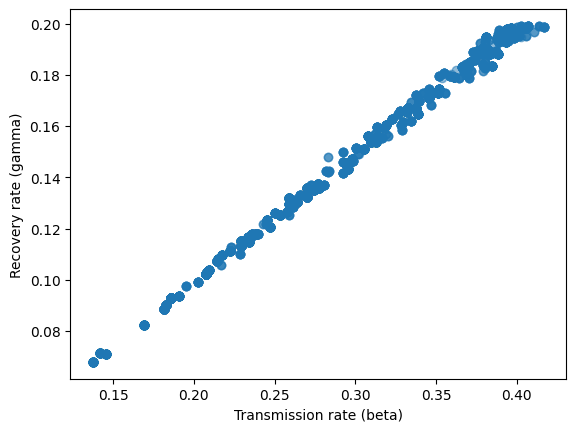

In [10]:
sim_samples = mcmc_sim.get_samples()
    
plt.scatter(sim_samples['beta'], sim_samples['gamma'], alpha=0.5)
plt.xlabel('Transmission rate (beta)')
plt.ylabel('Recovery rate (gamma)')
plt.show()

## 3. Calibrate with emulator

For more complex simulators, it is recommended to first train an emulator to approximate the simulator and then use the emulator for calibration. This is because calibration typically requires thousands of evaluations of the simulator, which can be computationally expensive.

`AutoEmulate` provides the `BayesCalibrator` class to perform Bayesian calibration with an emulator.

First we need to train an emulator. For the purposes of this tutorial, we will restrict the emulator choice to `GaussianProcess` with default hyperparameters.

In [11]:
ae = AutoEmulate(
    x, 
    y, 
    models=[GaussianProcessRBF], 
    # use default parameters
    model_params={},
    log_level="error",
    device="cpu",  
)

We can verify that the fitted emulator performs well on both the train and test data.

In [12]:
ae.summarise()

,model_name,x_transforms,y_transforms,params,r2_test,r2_test_std,rmse_test,rmse_test_std,r2_train,r2_train_std,rmse_train,rmse_train_std
0,GaussianProcessRBF,[StandardizeTransform()],[StandardizeTransform()],{'likelihood_cls': <class 'gpytorch.likelihood...,0.999974,0.000005,0.00112,0.000101,0.999979,0.000002,0.001106,0.000048


In [13]:
gp = ae.best_result().model

The `BayesianCalibration` object takes as input the trained emulator, the simulator parameter ranges and the "observed" data simulated above. 

The underlying probabilistic model is the same one used on the simulator example above. It assumes the observations are drawn from a Gaussian distribution with the mean predicted by the emulator. The user also has to specify the `observation_noise` which is the variance of the Gaussian likelihood.

In [14]:
bc = BayesianCalibration(
    gp, 
    simulator.parameters_range, 
    observations, 
    # specify noise as variance
    observation_noise=stdev**2
)

Run MCMC using the NUTS sampler. The `BayesianCalibration` class uses Pyro under the hood. Below we use `pyro.set_rng_seed` to ensure reproducibility.

In [15]:
mcmc_emu = bc.run_mcmc(
    warmup_steps=250, 
    num_samples=1000,
    num_chains=2    
)

Warmup [1]:   0%|          | 0/1250 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1250 [00:00, ?it/s]

The above returns the Pyro `MCMC` object which has a number of useful methods associated with it. One can access all the posterior samples using `mcmc.get_samples()` or just the summary statistics using `mcmc.summary()`. This shows that the posterior mean estimates of the input parameters are close to the true values used to generate the observations.

## 3. Plotting with Arviz

The `BayesianCalibrator.to_arviz` method converts the `mcmc` object so that it is compatible with the Arviz plotting library. Using Arviz makes it very easy to produce all the standard plots of the calibration results as well as MCMC diagnostics.

In [14]:
az_data = bc.to_arviz(mcmc_emu, posterior_predictive=True)

The main plot of interest is the posterior distribution over the parameters given the observations. Below we plot the pairwise joint distribution and can see that the two parameters are correlated as expected. The results look very similar to the results obtained using the simulator directly above.

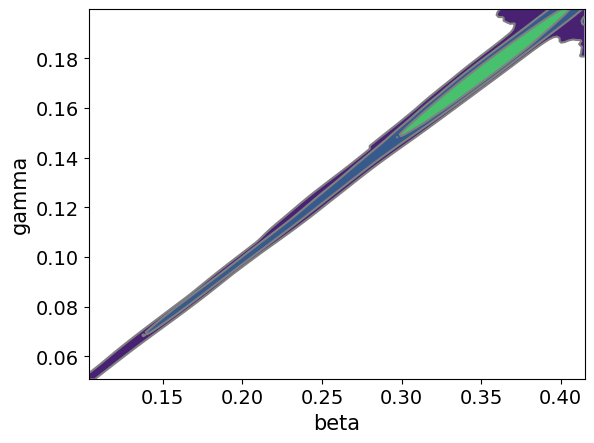

In [15]:
_ = az.plot_pair(az_data, kind='kde')

The posterior predictive samples can be plotted alongside the observed data. This shows that the calibration results capture the observed data well.

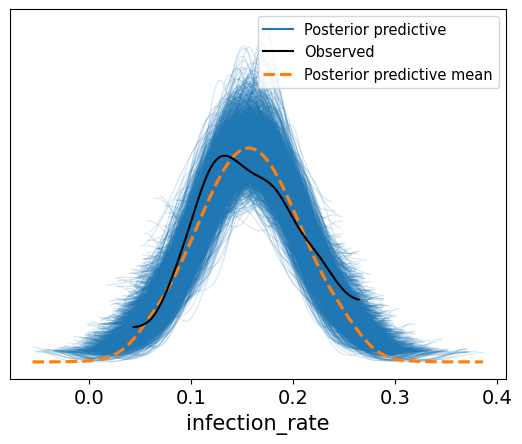

In [16]:
_ = az.plot_ppc(az_data)

To check the MCMC behaviour, the samples from the posterior distribution can be viewed as a trace (right-hand plots) with 1D KDEs for each chain for each variable (left-hand plots).

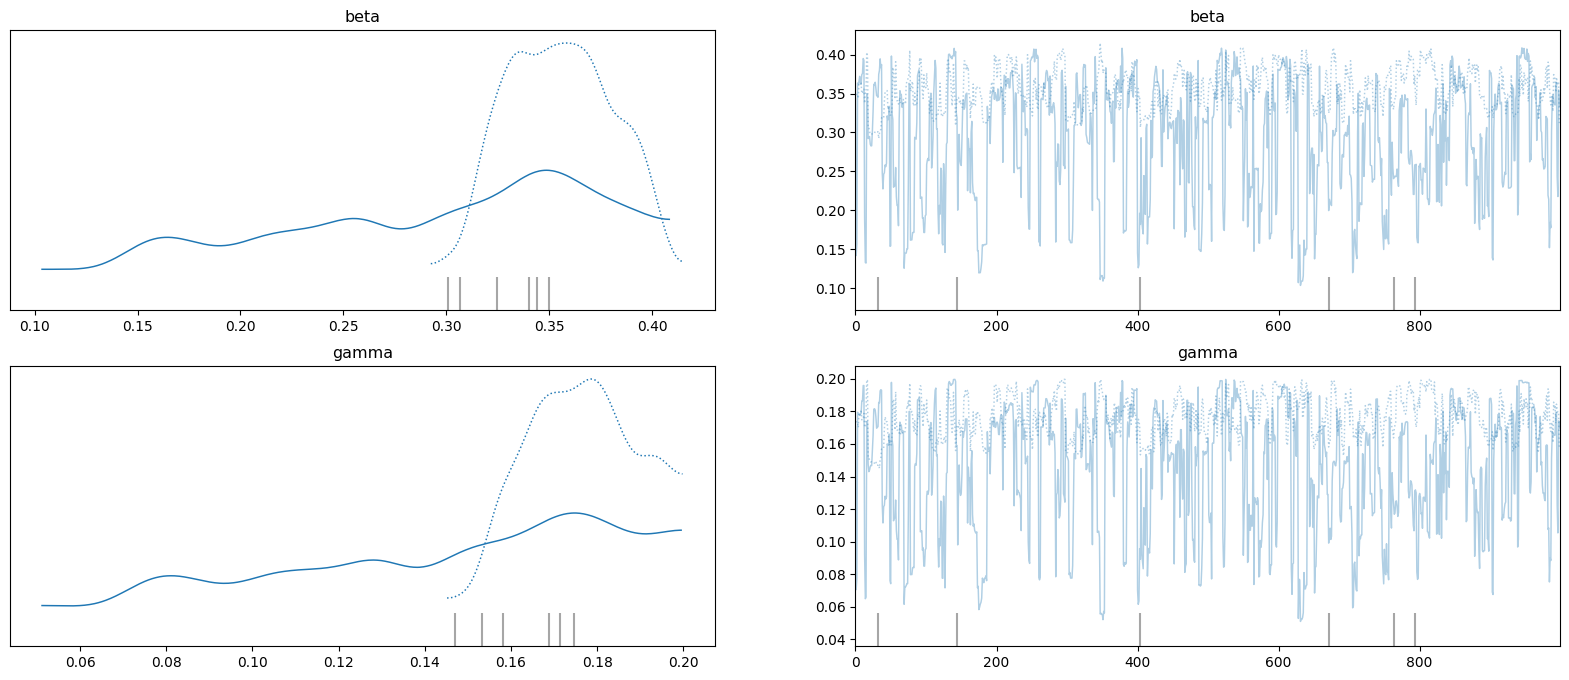

In [17]:
_ = az.plot_trace(az_data, figsize=(20, 8))

## 4. Plotting with GetDist

The `BayesianCalibration.to_getdist` static method converts an `mcmc` object so that it is compatible with the `getdist` plotting library. Alternatively, one can use the `arviz_to_mcsamples` function from GetDist to convert the Arviz data object to a GetDist `MCSamples` object. 

In [18]:
# convert simulator calibration samples
sim_data = BayesianCalibration.to_getdist(mcmc_sim, label="Simulator")

# convert emulator calibration samples
emu_data = arviz_to_mcsamples(az_data, dataset_label="Emulator")

Removed no burn in
Removed no burn in


Below we compare the posterior distributions obtained using the simulator and the emulator. Both distributions capture the true parameter values (indicated by the dashed lines). 

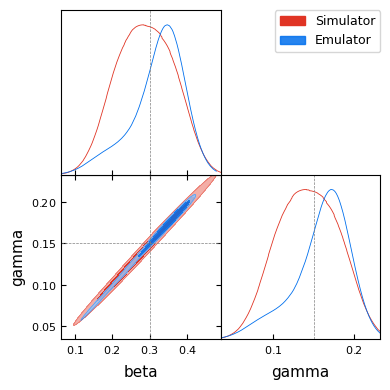

In [19]:
sim_data.smooth_scale_1D = 0.8
emu_data.smooth_scale_1D = 0.8

g = plots.get_subplot_plotter()
g.triangle_plot( 
    [sim_data, emu_data], 
    filled=True,
    markers={"beta": true_beta, "gamma": true_gamma},
)
plt.show()

# g.fig.savefig("bayes_calibration_getdist.png")

INFO:autoemulate:Running batch simulation for 1000 samples
DEBUG:autoemulate:Running simulation for sample 1/1000
DEBUG:autoemulate:Simulation 1/1000 successful
DEBUG:autoemulate:Running simulation for sample 2/1000
DEBUG:autoemulate:Simulation 2/1000 successful
DEBUG:autoemulate:Running simulation for sample 3/1000
DEBUG:autoemulate:Simulation 3/1000 successful
DEBUG:autoemulate:Running simulation for sample 4/1000
DEBUG:autoemulate:Simulation 4/1000 successful
DEBUG:autoemulate:Running simulation for sample 5/1000
DEBUG:autoemulate:Simulation 5/1000 successful
DEBUG:autoemulate:Running simulation for sample 6/1000
DEBUG:autoemulate:Simulation 6/1000 successful
DEBUG:autoemulate:Running simulation for sample 7/1000
DEBUG:autoemulate:Simulation 7/1000 successful
DEBUG:autoemulate:Running simulation for sample 8/1000
DEBUG:autoemulate:Simulation 8/1000 successful
DEBUG:autoemulate:Running simulation for sample 9/1000
DEBUG:autoemulate:Simulation 9/1000 successful
DEBUG:autoemulate:Runni

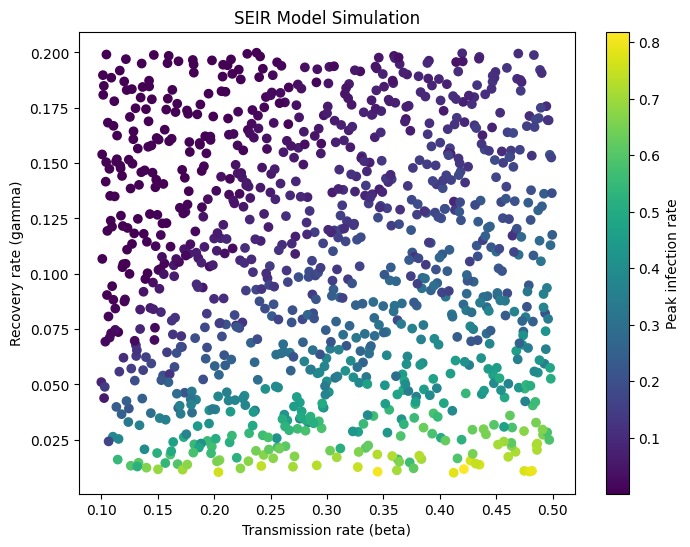

Sample: 100%|█| 16500/16500 [01:22, 199.11it/s, step size=7.18e-01, acc. prob=0.


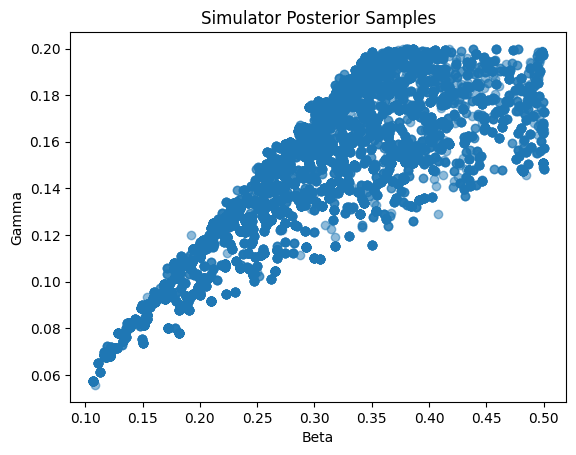

INFO:autoemulate:Comparing ['GaussianProcessRBF']
INFO:autoemulate:Running Model: GaussianProcessRBF: 1/1 (attempt 1/3)
DEBUG:autoemulate:Skipping tuning for model "GaussianProcessRBF", using defaultparameters
DEBUG:autoemulate:Running cross-validation for model "GaussianProcessRBF" for "10" iterations
DEBUG:autoemulate:Cross-validation for model "GaussianProcessRBF" completed with test metrics: r2: 0.999 (std: 0.001), rmse: 0.007 (std: 0.004)
INFO:autoemulate:Finished running Model: GaussianProcessRBF

INFO:autoemulate:Using metric 'r2' to determine best result.
DEBUG:autoemulate:Comparison results:
Best Model: GaussianProcessRBF, x transforms: [StandardizeTransform()], y transforms: [StandardizeTransform()], Best params: {'likelihood_cls': <class 'gpytorch.likelihoods.multitask_gaussian_likelihood.MultitaskGaussianLikelihood'>, 'epochs': 50, 'lr': 0.2, 'scheduler_params': <class 'inspect._empty'>}, Metrics: r2: 0.999, rmse: 0.007
INFO:autoemulate:Using metric 'r2' to determine best r

Warmup [1]:   0%|          | 0/1250 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1250 [00:00, ?it/s]

INFO:autoemulate:MCMC run completed.
INFO:autoemulate:Including posterior predictive samples in Arviz output.



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      0.31      0.10      0.32      0.13      0.45     52.56      1.04
     gamma      0.14      0.04      0.15      0.08      0.20     41.79      1.05
     sigma      0.16      0.07      0.14      0.05      0.27    293.85      1.01

Number of divergences: 17


DEBUG:autoemulate:Posterior predictive samples generated.
DEBUG:autoemulate:Using az.from_pyro for conversion.
INFO:autoemulate:Arviz InferenceData conversion complete.


Removed no burn in
Removed no burn in


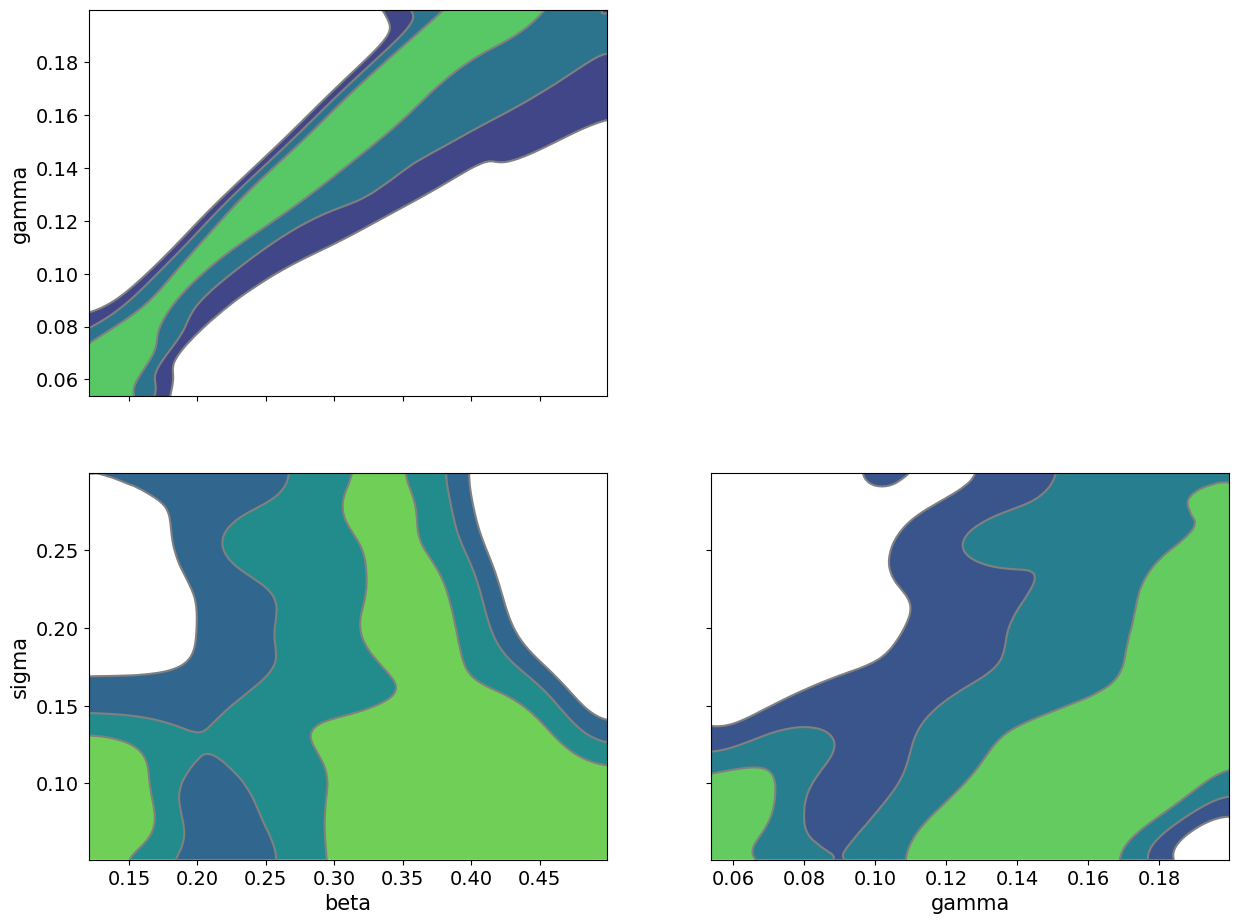

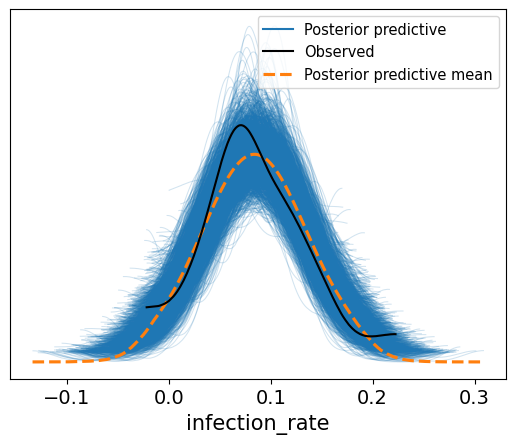

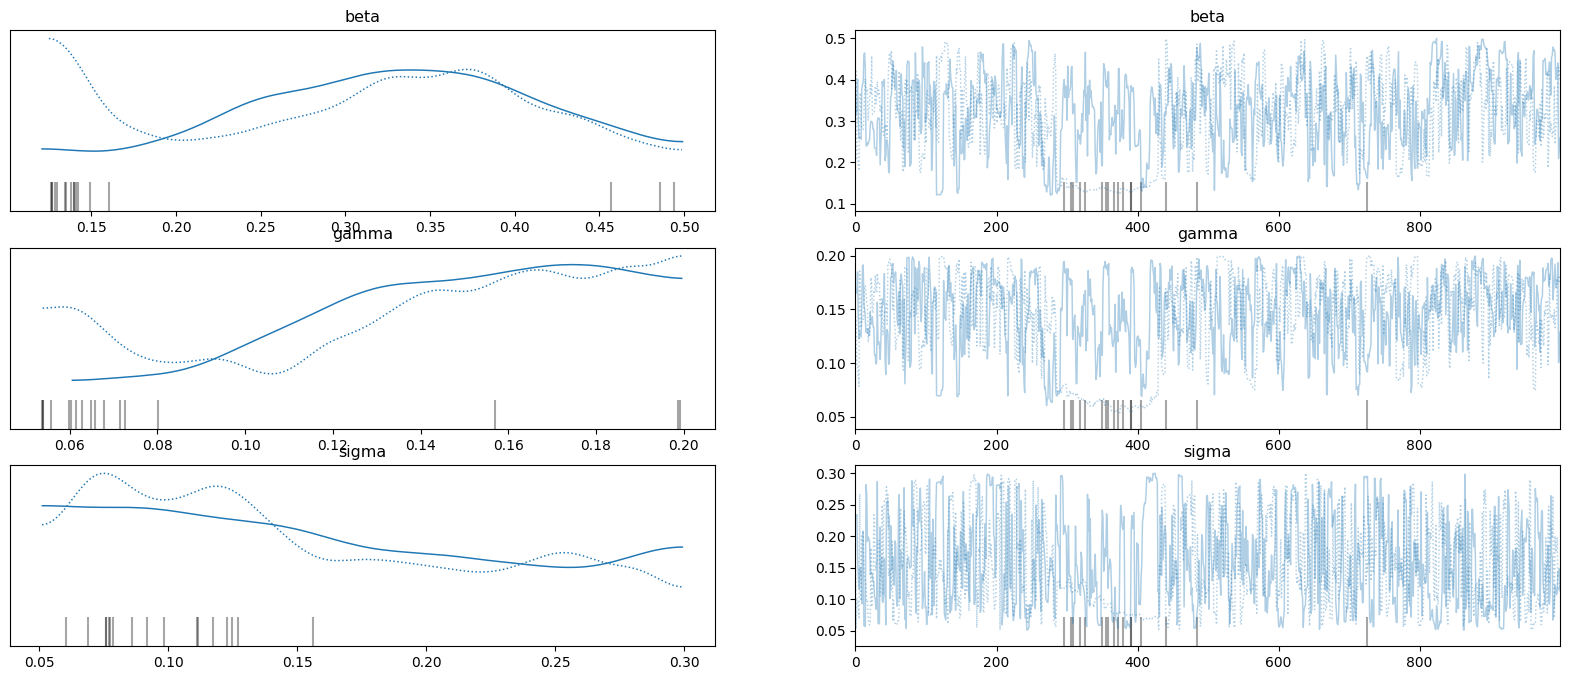

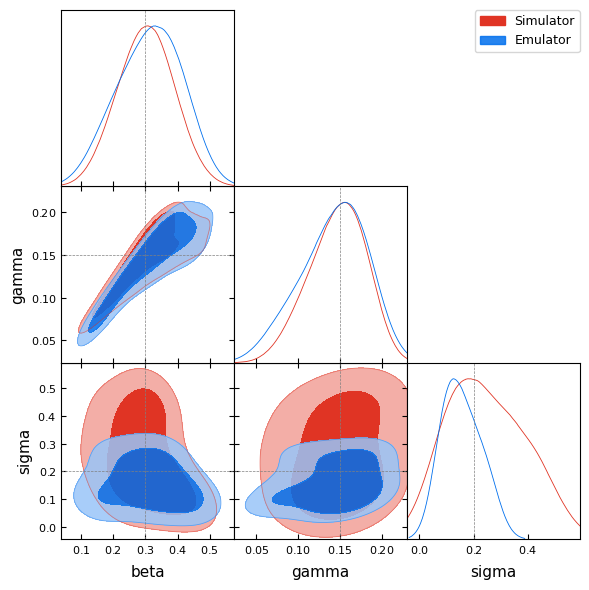

In [24]:
import numpy as np
import torch
from scipy.integrate import solve_ivp

from autoemulate.core.types import NumpyLike, TensorLike
from autoemulate.simulations.base import Simulator

class SEIRSimulator(Simulator):
    """
    Simulator of infectious disease spread using the SEIR model.
    """

    def __init__(
        self,
        parameters_range=None,
        output_names=None,
        log_level: str = "progress_bar",
    ):
        if parameters_range is None:
            parameters_range = {
                "beta": (0.1, 0.5),
                "gamma": (0.01, 0.2),
                "sigma": (0.05, 0.3)  # incubation rate
            }
        if output_names is None:
            output_names = ["infection_rate"]
        super().__init__(parameters_range, output_names, log_level)

    def _forward(self, x: TensorLike) -> TensorLike:
        """
        Simulate the epidemic using the SEIR model.

        Parameters
        ----------
        x: TensorLike
            input parameter values to simulate [beta, gamma, sigma]:
            - `beta`: transmission rate per day
            - `gamma`: recovery rate per day
            - `sigma`: incubation rate per day

        Returns
        -------
        TensorLike
            Peak infection rate.
        """
        assert x.shape[0] == 1, (
            f"Simulator._forward expects a single input, got {x.shape[0]}"
        )
        y = simulate_seir_epidemic(x.cpu().numpy()[0])
        return torch.tensor([y], dtype=torch.float32).view(-1, 1)

def simulate_seir_epidemic(x: NumpyLike, N: int = 1000, I0: int = 1, E0: int = 0) -> float:
    """
    Simulate an epidemic using the SEIR model.

    Parameters
    ----------
    x: NumpyLike
        The parameters of the SEIR model. [beta, gamma, sigma]
    N: int
        Total population
    I0: int
        Initial number of infected individuals
    E0: int
        Initial number of exposed individuals

    Returns
    -------
    peak_infection_rate: float
        The peak infection rate as a fraction of the total population.
    """
    assert len(x) == 3
    beta, gamma, sigma = x

    S0 = N - I0 - E0
    R0 = 0
    t_span = [0, 160]
    y0 = [S0, E0, I0, R0]

    def seir_model(t, y, N, beta, gamma, sigma):
        S, E, I, R = y
        dSdt = -beta * S * I / N
        dEdt = beta * S * I / N - sigma * E
        dIdt = sigma * E - gamma * I
        dRdt = gamma * I
        return [dSdt, dEdt, dIdt, dRdt]

    t_eval = np.linspace(t_span[0], t_span[1], 160)
    sol = solve_ivp(seir_model, t_span, y0, args=(N, beta, gamma, sigma), t_eval=t_eval)

    S, E, I, R = sol.y
    I_max = np.max(I)

    return I_max / N  # peak infection rate same as Epidemic SIR model


simulator = SEIRSimulator(log_level="error")
x = simulator.sample_inputs(1000)
y, _ = simulator.forward_batch(x)

# Plot
transmission_rate = x[:, 0]
recovery_rate = x[:, 1]
exposure_rate = x[:, 2]

plt.figure(figsize=(8, 6))
sc = plt.scatter(transmission_rate, recovery_rate, c=y, cmap='viridis')
plt.xlabel('Transmission rate (beta)')
plt.ylabel('Recovery rate (gamma)')
plt.colorbar(sc, label="Peak infection rate")
plt.title("SEIR Model Simulation")
plt.show()

# Step 2: Observed data
true_beta = 0.3
true_gamma = 0.15
true_sigma = 0.2
params = torch.tensor([true_beta, true_gamma, true_sigma]).view(1, -1)
true_infection_rate = simulator.forward(params)

n_obs = 100
stdev = 0.05
noise = torch.normal(mean=0, std=stdev, size=(n_obs,))
observed_infection_rates = true_infection_rate[0] + noise
observations = {"infection_rate": observed_infection_rates}

# Step 3: Calibrate with simulator using Pyro
import pyro.distributions as dist
from pyro.infer import MCMC
from pyro.infer.mcmc import RandomWalkKernel

def model():
    beta = pyro.sample("beta", dist.Uniform(0.1, 0.5))
    gamma = pyro.sample("gamma", dist.Uniform(0.01, 0.2))
    sigma = pyro.sample("sigma", dist.Uniform(0.05, 0.5))

    mean = simulator.forward(torch.tensor([[beta, gamma, sigma]]))

    with pyro.plate("data", n_obs):
        pyro.sample(
            "infection_rate",
            dist.Normal(mean, stdev),
            obs=observations["infection_rate"],
        )

kernel = RandomWalkKernel(model, init_step_size=2.5)
mcmc_sim = MCMC(kernel, warmup_steps=1500, num_samples=15000, num_chains=1) #might have to increase warmup syeps and num of samples for convergence
mcmc_sim.run()

sim_samples = mcmc_sim.get_samples()
plt.scatter(sim_samples['beta'], sim_samples['gamma'], alpha=0.5)
plt.xlabel('Beta')
plt.ylabel('Gamma')
plt.title('Simulator Posterior Samples')
plt.show()

# Step 4: Train Emulator and Calibrate
from autoemulate.core.compare import AutoEmulate
from autoemulate.emulators import GaussianProcessRBF
from autoemulate.calibration.bayes import BayesianCalibration

ae = AutoEmulate(x, y, models=[GaussianProcessRBF], model_params={}, log_level="error")
ae.summarise()
gp = ae.best_result().model

bc = BayesianCalibration(
    gp,
    simulator.parameters_range,
    observations,
    observation_noise=stdev**2,
)

mcmc_emu = bc.run_mcmc(warmup_steps=250, num_samples=1000, num_chains=2)
mcmc_emu.summary()

# Step 5: Plotting
az_data = bc.to_arviz(mcmc_emu, posterior_predictive=True)
_ = az.plot_pair(az_data, kind='kde')
_ = az.plot_ppc(az_data)
_ = az.plot_trace(az_data, figsize=(20, 8))

# Step 6: Compare Posterior Distributions
sim_data = BayesianCalibration.to_getdist(mcmc_sim, label="Simulator")
emu_data = arviz_to_mcsamples(az_data, dataset_label="Emulator")
sim_data.smooth_scale_1D = 0.8
emu_data.smooth_scale_1D = 0.8

g = plots.get_subplot_plotter()
g.triangle_plot(
    [sim_data, emu_data],
    filled=True,
    markers={"beta": true_beta, "gamma": true_gamma, "sigma": true_sigma},
)
plt.show()


In [ ]:
import numpy as np
import torch
from scipy.integrate import solve_ivp

from autoemulate.core.types import NumpyLike, TensorLike
from autoemulate.simulations.base import Simulator


class SEIRTrajectorySimulator(Simulator):
    """
    SEIR simulator that returns I(t)/N at a set of time points (trajectory).
    """

    def __init__(
        self,
        parameters_range=None,
        t_grid=None,              # time points at which we observe I(t)
        output_names=None,
        log_level: str = "progress_bar",
    ):
        # Parameter ranges as before
        if parameters_range is None:
            parameters_range = {
                "beta": (0.1, 0.5),
                "gamma": (0.01, 0.2),
                "sigma": (0.05, 0.3),  # incubation rate
            }

        # Choose 10 time points in [0, 160]
        if t_grid is None:
            self.t_grid = np.linspace(20.0, 140.0, 10)  # shape (T,)
        else:
            self.t_grid = np.array(t_grid, dtype=float)

        # One output per time point: I(t_k)/N
        if output_names is None:
            output_names = [f"I_t_{k}" for k in range(len(self.t_grid))]

        self.T = len(self.t_grid)
        super().__init__(parameters_range, output_names, log_level)

    def _forward(self, x: TensorLike) -> TensorLike:
        """
        Simulate the SEIR model and return I(t)/N at self.t_grid.

        Parameters
        ----------
        x: TensorLike
            Input parameters [beta, gamma, sigma].

        Returns
        -------
        TensorLike
            Shape [1, T] where T = len(self.t_grid), containing I(t_k)/N.
        """
        assert x.shape[0] == 1, (
            f"Simulator._forward expects a single input, got {x.shape[0]}"
        )
        theta = x.cpu().numpy()[0]  # [beta, gamma, sigma]
        y_traj = simulate_seir_trajectory(theta, t_grid=self.t_grid)
        # shape (T,) -> (1, T)
        return torch.tensor(y_traj, dtype=torch.float32).view(1, -1)


def simulate_seir_trajectory(
    x: NumpyLike,
    N: int = 1000,
    I0: int = 1,
    E0: int = 0,
    t_grid: NumpyLike | None = None,
) -> np.ndarray:
    """
    Simulate an epidemic using the SEIR model and return I(t)/N at t_grid.

    Parameters
    ----------
    x: NumpyLike
        Parameters [beta, gamma, sigma].
    N: int
        Total population.
    I0: int
        Initial number of infected individuals.
    E0: int
        Initial number of exposed individuals.
    t_grid: NumpyLike
        Times at which to return I(t)/N.

    Returns
    -------
    np.ndarray
        Array of shape (T,) with I(t_k)/N at each t_k in t_grid.
    """
    assert len(x) == 3
    beta, gamma, sigma = x

    S0 = N - I0 - E0
    R0 = 0.0

    # If no t_grid is given, default to 10 points (for direct calls)
    if t_grid is None:
        t_grid = np.linspace(20.0, 140.0, 10)
    t_grid = np.array(t_grid, dtype=float)

    t_span = [t_grid.min(), t_grid.max()]
    y0 = [S0, E0, I0, R0]

    def seir_model(t, y, N, beta, gamma, sigma):
        S, E, I, R = y
        dSdt = -beta * S * I / N
        dEdt = beta * S * I / N - sigma * E
        dIdt = sigma * E - gamma * I
        dRdt = gamma * I
        return [dSdt, dEdt, dIdt, dRdt]

    # Solve ODE at the desired times
    sol = solve_ivp(
        seir_model,
        t_span,
        y0,
        args=(N, beta, gamma, sigma),
        t_eval=t_grid,
    )

    S, E, I, R = sol.y
    I_frac = I / N  # I(t)/N
    return I_frac  # shape (T,)

# Instantiate trajectory-based SEIR simulator
simulator = SEIRTrajectorySimulator(log_level="error")
t_grid = simulator.t_grid   # 10 time points
T = len(t_grid)

# Sample training inputs and corresponding trajectories
x = simulator.sample_inputs(1000)      # shape (1000, 3)
y, _ = simulator.forward_batch(x)      # shape (1000, T)

print("x shape:", x.shape)
print("y shape:", y.shape)  # (1000, 10)
# True parameters (for synthetic "observed" trajectory)
true_beta = 0.3
true_gamma = 0.15
true_sigma = 0.2

params = torch.tensor([true_beta, true_gamma, true_sigma]).view(1, -1)
true_traj = simulator.forward(params).squeeze(0)   # shape (T,)

stdev = 0.05  # observation noise std per time point

# Single observed trajectory: true I(t)/N + noise
observed_traj = true_traj + torch.normal(
    mean=torch.zeros_like(true_traj),
    std=stdev,
)

# Build observations dict: one scalar observation per "output" (time point)
observations = {}
for name, value in zip(simulator.output_names, observed_traj):
    # each is a 1D tensor of length 1
    observations[name] = value.view(1)

observations
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC
from pyro.infer.mcmc import NUTS

pyro.clear_param_store()
pyro.set_rng_seed(random_seed)


def seir_traj_model():
    # Priors
    beta = pyro.sample("beta", dist.Uniform(0.1, 0.5))
    gamma = pyro.sample("gamma", dist.Uniform(0.01, 0.2))
    sigma = pyro.sample("sigma", dist.Uniform(0.05, 0.3))

    # Simulator forward: trajectory at 10 time points
    theta_vec = torch.tensor([[beta, gamma, sigma]])
    mean_traj = simulator.forward(theta_vec).squeeze(0)   # shape (T,)

    # Likelihood over time points (independent normals)
    with pyro.plate("time", T):
        pyro.sample(
            "I_t",                      # a single RV with shape (T,)
            dist.Normal(mean_traj, stdev),
            obs=observed_traj,
        )


# Run MCMC with NUTS on the simulator model
nuts_kernel_sim = NUTS(seir_traj_model)
mcmc_sim = MCMC(
    nuts_kernel_sim,
    warmup_steps=500,
    num_samples=2000,
    num_chains=1,
)
mcmc_sim.run()

sim_samples = mcmc_sim.get_samples()
plt.scatter(sim_samples['beta'], sim_samples['gamma'], alpha=0.5)
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('Simulator posterior samples (SEIR, trajectory)')
plt.show()
from autoemulate.core.compare import AutoEmulate
from autoemulate.emulators import GaussianProcessRBF
from autoemulate.calibration.bayes import BayesianCalibration

# Train multi-output GP emulator on (beta, gamma, sigma) -> I(t_1..t_10)/N
ae = AutoEmulate(
    x,
    y,
    models=[GaussianProcessRBF],
    model_params={},      # defaults are fine here
    log_level="error",
)
ae.summarise()
gp = ae.best_result().model

# Bayesian calibration with emulator, using the trajectory
bc = BayesianCalibration(
    gp,
    simulator.parameters_range,  # includes beta, gamma, sigma
    observations,
    observation_noise=stdev**2,  # scalar variance applied to each output
    model_uncertainty=False,     # keep simple for now
)

# Run MCMC with NUTS using the emulator
mcmc_emu = bc.run_mcmc(
    warmup_steps=500,
    num_samples=2000,
    num_chains=2,
)
mcmc_emu.summary()
# Convert emulator MCMC to ArviZ
az_data = bc.to_arviz(mcmc_emu, posterior_predictive=True)

# Joint posterior over parameters
_ = az.plot_pair(az_data, kind='kde')
plt.show()

# Posterior predictive vs observed trajectory
_ = az.plot_ppc(az_data)
plt.show()

# Trace plots
_ = az.plot_trace(az_data, figsize=(20, 8))
plt.show()

# Compare simulator vs emulator posteriors (trajectory-based)
from getdist.arviz_wrapper import arviz_to_mcsamples
from getdist import plots

sim_data = BayesianCalibration.to_getdist(mcmc_sim, label="Simulator")
emu_data = arviz_to_mcsamples(az_data, dataset_label="Emulator")

sim_data.smooth_scale_1D = 0.8
emu_data.smooth_scale_1D = 0.8

g = plots.get_subplot_plotter()
g.triangle_plot(
    [sim_data, emu_data],
    filled=True,
    markers={"beta": true_beta, "gamma": true_gamma, "sigma": true_sigma},
)
plt.show()



x shape: torch.Size([1000, 3])
y shape: torch.Size([1000, 10])


Warmup:   1%|  | 14/2500 [00:30,  3.32s/it, step size=2.18e-04, acc. prob=0.506]